In [67]:
import geopandas as gp
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.linear_model import LinearRegression
import contextily as ctx
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

import util

In [60]:
# Config and Setup
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","blue","purple"])

# Load Shapefile with State Data 
- Data contains: 
    - name: State name
    - rent: median contract rent
    - price: median home value 
    - geometry: polygon used to plot shape of state
    - price_to_rent: calculated using by taking the quotient of median home value and twelve months of median rent 


In [74]:
states_gdf = gp.read_file('data/shapefiles/states/states.shp')
# Puerto Rico is removed since analysis is only concerned with US States, not territories 
states_gdf = states_gdf[~states_gdf['NAME'].isin(["Puerto Rico",])]
# Calculate price to rent ratio column 
states_gdf['price_to_rent'] = states_gdf['MEDIAN_HOM']/(states_gdf["MEDIAN_CON"]*12)
# Rename columns to be more readable
states_gdf = states_gdf.rename(columns={
    "MEDIAN_CON":"rent", 
    "MEDIAN_HOM":"price", 
    "NAME":"name"}
)
# Simplify geometries to improve performance 
states_gdf["geometry"] = states_gdf["geometry"].apply(lambda x: x.simplify(0.05))
# Convert all geometries of type Polygon to MultiPolygon (need for geojson export)
states_gdf["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in states_gdf["geometry"]]
# Save data as geojson for use with Chart.js graphs and maps
states_gdf.to_file('geojson/states.geojson', driver='GeoJSON')
# Set coordinate reference system to epsg 3857
states_gdf = states_gdf.to_crs(epsg=3857)
states_gdf.head()

,name,rent,price,geometry,price_to_rent
0,New Hampshire,959,270000,(POLYGON ((-8051727.525808907 5403781.38760635...,23.461940
1,Hawaii,1475,631700,(POLYGON ((-17302707.05038116 2290240.64648289...,35.689266
2,Minnesota,876,235400,(POLYGON ((-10773988.00966218 5881970.09428895...,22.393455
3,Louisiana,692,167300,(POLYGON ((-10249085.88639244 3896387.51524502...,20.146917
4,Wisconsin,722,188500,(POLYGON ((-10340140.99972069 5723505.92036130...,21.756694


# Create Linear Regression Model and Plot Scatter Chart
- Create linear regressor using sklearn LinearRegression
- Predict Y values for target column 
- Use scipy linregress to show slope, rvalue, pvalue and standard error
- Plot scatter plot and predicted Y values from linear regression model

In [75]:
 # create object for the class
linear_regressor = LinearRegression()
# perform linear regression
linear_regressor.fit(
    states_gdf[['rent']],
    states_gdf[['price_to_rent']]
)
# make predictions
Y_pred = linear_regressor.predict(states_gdf[['rent']])

# Get r-value, p-value, and slope
linregress(states_gdf['price_to_rent'], states_gdf['price'])

LinregressResult(slope=23977.667485491365, intercept=-306029.25163436064, rvalue=0.89379601706149636, pvalue=1.0873812172463024e-18, stderr=1718.7292964599253)

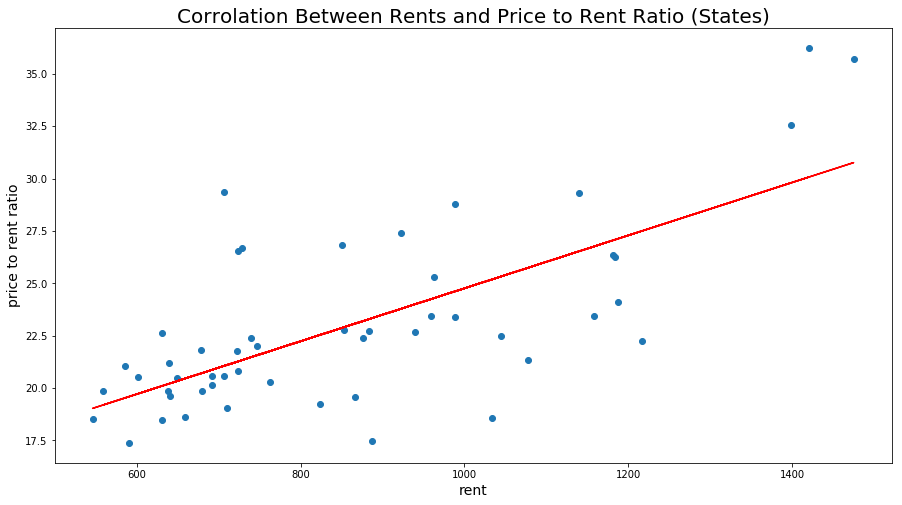

In [76]:
plt.figure(figsize=(15,8))

plt.scatter(
    states_gdf["rent"], 
    states_gdf["price_to_rent"],
)
plt.plot(
    states_gdf[['rent']], 
    Y_pred, 
    color='red',
)

plt.xlabel('rent', fontsize=14)
plt.ylabel('price to rent ratio', fontsize=14)
plt.title('Corrolation Between Rents and Price to Rent Ratio (States)',  fontsize=20)

plt.show()

# Plot Map For Each State's Price to Rent Ratio 
- Add basemap from contextily library
- Plot colorbar using CMAP global defined in config step above
- Save image in /images directory

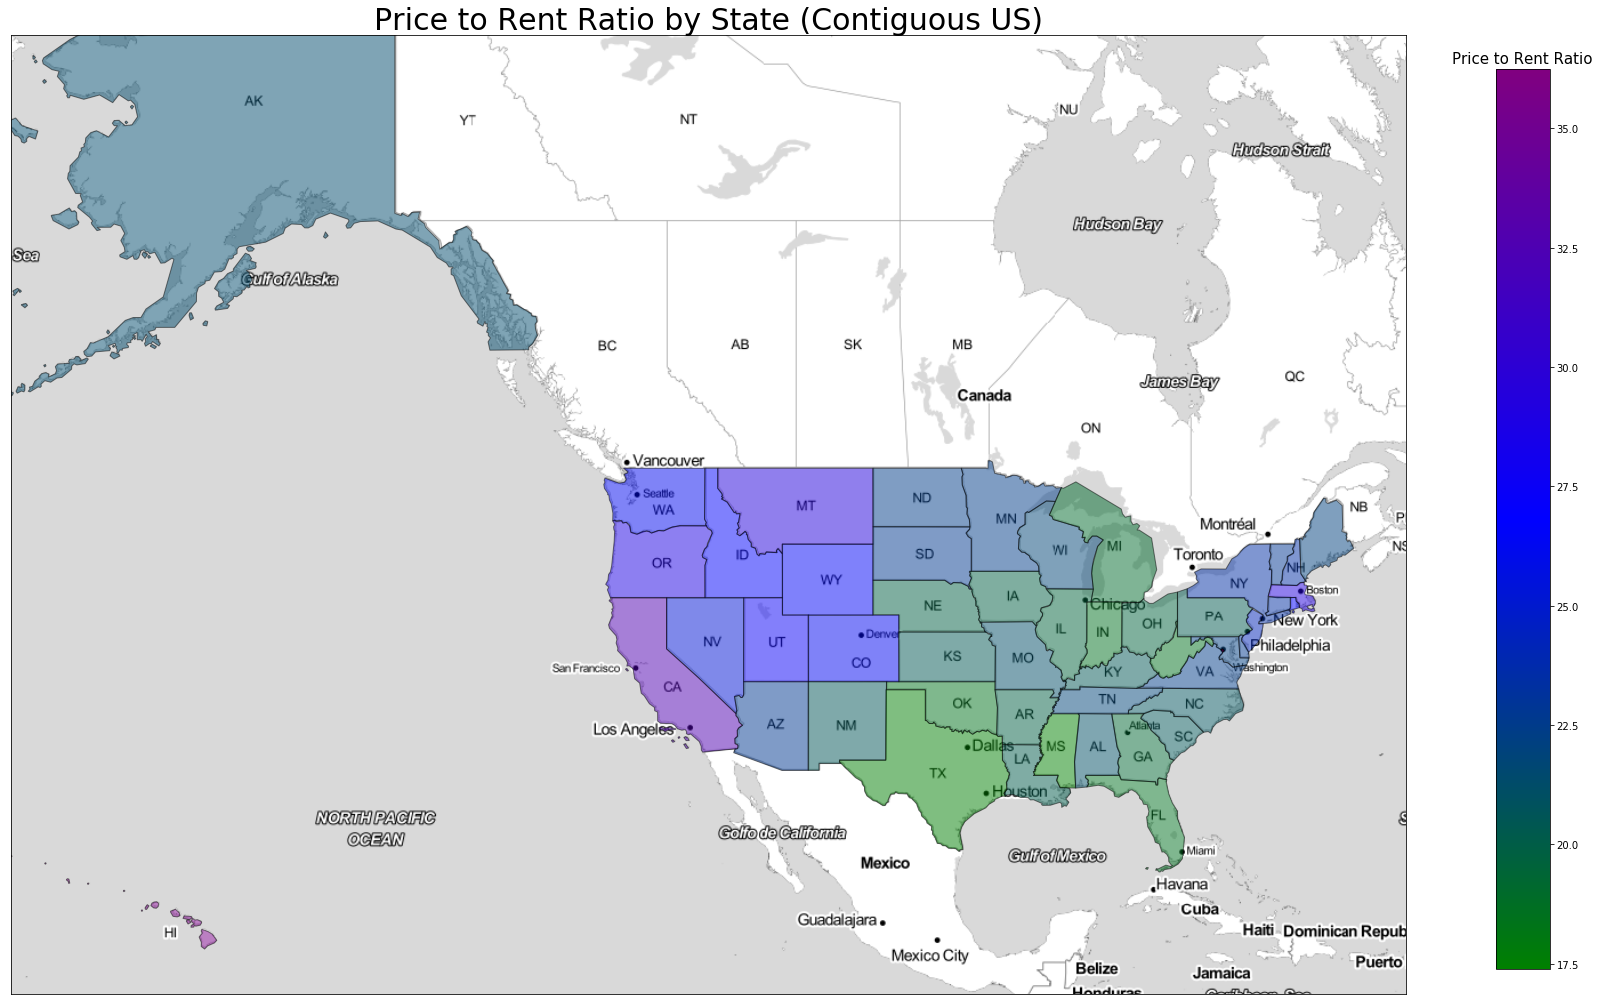

In [77]:
column = "price_to_rent"
title = "Price to Rent Ratio by State (Contiguous US)"
vmin = states_gdf[column].min()
vmax = states_gdf[column].max()

ax = states_gdf.plot(
    column=column,
    cmap=CMAP,
    figsize=(25, 25),
    alpha=0.5,
    edgecolor='black',
    linewidth=1,
)

util.add_basemap(ax, zoom=4, url=ctx.sources.ST_TONER_LITE)

ax.set_xlim(-19000000, -7000000)
ax.set_ylim(1750000, 10000000)

fig = ax.get_figure()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Add color bar
cbax = fig.add_axes([0.95, 0.25, 0.03, 0.5])   
cbax.set_title("Price to Rent Ratio", fontsize= 15)
sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cbax)

ax.set_title(title, fontdict={
    'fontsize': 30, 'fontweight': 'medium'})


plt.savefig('images/{}.jpg'.format(title),  dpi=300, bbox_inches = "tight")
plt.show()